# Week 3: Fast pipelines, profiling

### Seminar outline
- Automatic mixed precision (AMP) and tensor cores
- Efficient batching
- HuggingFace streaming dataset
- Image decoders benchmarks
- General purpose Python profiling with `py-spy`
- Deep Learning profiling with `torch.utils.bottleneck()`
- Profiling with `nvprof`

## Before we start

In [1]:
# HuggingFace datasets
# !pip install datasets

# NVidia DALI
# Make sure to choose correct CUDA version according to the nvidia-smi output
# pip install --extra-index-url https://developer.download.nvidia.com/compute/redist --upgrade nvidia-dali-cuda110

# Image decoding libraries
# !sudo apt install libturbojpeg
# !pip install opencv-python scikit-image jpeg4py

# Profiling
# !pip install py-spy nvprof

In [2]:
# !nvidia-smi

## Automatic mixed precision
Let's use a simple MNIST training example to see the difference between full precision training, half precision training and mixed precision training.

In [3]:
import gc
from time import time
from typing import Literal

import torch
import torch.nn as nn
import torchvision
from tqdm.auto import tqdm, trange

In [4]:
# very standard data things
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

mnist_train = torchvision.datasets.MNIST(
    "./mnist/", train=True, download=True, transform=transform
)
mnist_val = torchvision.datasets.MNIST(
    "./mnist/", train=False, download=True, transform=transform
)


train_dataloader = torch.utils.data.DataLoader(
    mnist_train, batch_size=1024, shuffle=True
)
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=1024, shuffle=False)

In [5]:
# train loop is adapted for full and half precisions training modes
def train(
    model: nn.Module,
    loss_fn: nn.modules.loss,
    optimizer: torch.optim.Optimizer,
    n_epochs: int = 3,
    device: torch.device = "cuda:0",
    precision: Literal["full", "half"] = "full",
    loss_scaling: bool = False,
) -> None:

    assert not (
        loss_scaling and precision == "half"
    ), "Cannot use standard loss scaler with FP16 model weights"

    if loss_scaling:
        scaler = torch.cuda.amp.GradScaler()
    if precision == "half":
        model.half()
    model.to(device)

    for epoch in range(n_epochs):
        model.train()
        for x_train, y_train in tqdm(train_dataloader, desc=f"Epoch {epoch}: "):
            if precision == "half":
                x_train = x_train.half()
            x_train, y_train = x_train.to(device), y_train.to(device)
            y_pred = model(x_train)

            loss = loss_fn(y_pred, y_train)

            if loss_scaling:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()
            optimizer.zero_grad()

        if epoch % 2 == 0 or epoch == n_epochs - 1:
            print("Starting validation...")
            model.eval()
            val_loss = torch.empty(len(val_dataloader))
            val_accuracy = torch.empty(len(val_dataloader))

            with torch.no_grad():
                for i, (x_val, y_val) in enumerate(val_dataloader):
                    if precision == "half":
                        x_val = x_val.half()
                    x_val, y_val = x_val.to(device), y_val.to(device)
                    y_pred = model(x_val)
                    loss = loss_fn(y_pred.float(), y_val)
                    val_loss[i] = loss
                    val_accuracy[i] = (
                        (torch.argmax(y_pred, dim=-1) == y_val).float().mean()
                    )

            print(
                f"Epoch: {epoch}, loss: {val_loss.mean().detach().cpu()}, "
                f"accuracy: {val_accuracy.mean().detach().cpu()}"
            )
    model.eval()

Firstly, let's check that full precision training converges to a reasonable accuracy score.

In [6]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    nn.Conv2d(in_channels=20, out_channels=10, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(2 * 2 * 10, 128),
    nn.ReLU(),
    nn.Linear(128, 1024),
    nn.ReLU(),
    nn.Linear(1024, 10),
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss = nn.CrossEntropyLoss()

train(model, loss, optimizer)

Epoch 0:   0%|          | 0/59 [00:00<?, ?it/s]

Starting validation...
Epoch: 0, loss: 0.10489548742771149, accuracy: 0.9636977910995483


Epoch 1:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/59 [00:00<?, ?it/s]

Starting validation...
Epoch: 2, loss: 0.09130456298589706, accuracy: 0.9695650935173035


Now, let's try to cast both the model and the data to half precision. Training process diverges because of the division on overflowed values in Adam.

In [7]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    nn.Conv2d(in_channels=20, out_channels=10, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(2 * 2 * 10, 128),
    nn.ReLU(),
    nn.Linear(128, 1024),
    nn.ReLU(),
    nn.Linear(1024, 10),
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss = nn.CrossEntropyLoss()

train(model, loss, optimizer, precision="half", n_epochs=1)

Epoch 0:   0%|          | 0/59 [00:00<?, ?it/s]

Starting validation...
Epoch: 0, loss: nan, accuracy: 0.09818439185619354


Notice, that we can also get not `NaN`s but just a diverged process if we use another optimizer which avoids divisions. Nevertheless, we cannot achive good model quality because of the gradients underflow.

In [8]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    nn.Conv2d(in_channels=20, out_channels=10, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(2 * 2 * 10, 128),
    nn.ReLU(),
    nn.Linear(128, 1024),
    nn.ReLU(),
    nn.Linear(1024, 10),
)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss = nn.CrossEntropyLoss()

train(model, loss, optimizer, precision="half", n_epochs=1)

Epoch 0:   0%|          | 0/59 [00:00<?, ?it/s]

Starting validation...
Epoch: 0, loss: 2.2862002849578857, accuracy: 0.14319993555545807


Ok, let's get to AMP. Check out that there are two different ways how you can apply autocast to Pytorch operations.

In [9]:
# @torch.cuda.amp.autocast
# def forward_batch(x_train, y_train, model, loos_fn, device):
#     x_train, y_train = x_train.to(device), y_train.to(device)
#     y_pred = model(x_train)

#     loss = loss_fn(y_pred, y_train)


def train(
    model: nn.Module,
    loss_fn: nn.modules.loss,
    optimizer: torch.optim.Optimizer,
    n_epochs: int = 3,
    device: torch.device = "cuda:0",
):
    scaler = torch.cuda.amp.GradScaler()
    model.to(device)

    for epoch in range(n_epochs):
        model.train()
        # it fails in this case. why?
        # with torch.cuda.amp.autocast():
        for x_train, y_train in tqdm(train_dataloader, desc=f"Epoch {epoch}: "):
            with torch.cuda.amp.autocast():
                x_train, y_train = x_train.to(device), y_train.to(device)
                y_pred = model(x_train)

                loss = loss_fn(y_pred, y_train)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        if epoch % 2 == 0 or epoch == n_epochs - 1:
            print("Starting validation...")
            model.eval()
            val_loss = torch.empty(len(val_dataloader))
            val_accuracy = torch.empty(len(val_dataloader))

            with torch.no_grad():
                for i, (x_val, y_val) in enumerate(val_dataloader):
                    x_val, y_val = x_val.to(device), y_val.to(device)
                    y_pred = model(x_val)
                    loss = loss_fn(y_pred, y_val)
                    val_loss[i] = loss
                    val_accuracy[i] = (
                        (torch.argmax(y_pred, dim=-1) == y_val).float().mean()
                    )

            print(
                f"Epoch: {epoch}, loss: {val_loss.mean().detach().cpu()}, "
                f"accuracy: {val_accuracy.mean().detach().cpu()}"
            )
    model.eval()


model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    nn.Conv2d(in_channels=20, out_channels=10, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(2 * 2 * 10, 128),
    nn.ReLU(),
    nn.Linear(128, 1024),
    nn.ReLU(),
    nn.Linear(1024, 10),
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss = nn.CrossEntropyLoss()


train(model, loss, optimizer)

Epoch 0:   0%|          | 0/59 [00:00<?, ?it/s]

Starting validation...
Epoch: 0, loss: 0.37641310691833496, accuracy: 0.8758330345153809


Epoch 1:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/59 [00:00<?, ?it/s]

Starting validation...
Epoch: 2, loss: 0.17395998537540436, accuracy: 0.9424784779548645


Note: the original model weights are always in full precision. However, under the hood, there is also a FP16 copy of the model, thus fast gradients computation can be done.

In [10]:
model[0].weight.dtype

torch.float32

In this section we will briefly examine time and memory consumption of full, half and mixed precision modes. Actually, the results are pretty much expectable.

In [11]:
# Timing utilities
start_time = None


def start_timer():
    global start_time
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.reset_max_memory_allocated()
    torch.cuda.synchronize()
    start_time = time()


def end_timer_and_print(local_msg):
    torch.cuda.synchronize()
    end_time = time()
    print("\n" + local_msg)
    print("Total execution time = {:.3f} sec".format(end_time - start_time))
    print(
        "Max memory used by tensors = {} bytes".format(
            torch.cuda.max_memory_allocated()
        )
    )

In [12]:
def make_model(in_size: int, out_size: int, num_layers: int):
    layers = []
    for _ in range(num_layers - 1):
        layers.append(torch.nn.Linear(in_size, in_size))
        layers.append(torch.nn.ReLU())
    layers.append(torch.nn.Linear(in_size, out_size))
    return torch.nn.Sequential(*tuple(layers))

In [13]:
batch_size = 512  # Try, for example, 128, 256, 513
in_size = 4096 + 2048
out_size = 4096 + 2048
num_layers = 3
num_batches = 50
epochs = 3

# Creates data in default precision.
# The same data is used for both default and mixed precision trials below.
# You don't need to manually change inputs' dtype when enabling mixed precision.
data = [torch.randn(batch_size, in_size, device="cuda:0") for _ in range(num_batches)]
targets = [
    torch.randn(batch_size, out_size, device="cuda:0") for _ in range(num_batches)
]

loss_fn = torch.nn.MSELoss().to("cuda:0")

In [14]:
net = make_model(in_size, out_size, num_layers)
opt = torch.optim.SGD(net.parameters(), lr=0.001)
net.to("cuda:0")

start_timer()
for epoch in trange(epochs):
    for input, target in zip(data, targets):
        output = net(input)
        loss = loss_fn(output, target)
        loss.backward()
        opt.step()
        opt.zero_grad()  # set_to_none=True here can modestly improve performance
end_timer_and_print("Full precision:")

/home/ubuntu/anaconda3/envs/ml/lib/python3.10/site-packages/torch/cuda/memory.py:278: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]


Full precision:
Total execution time = 4.038 sec
Max memory used by tensors = 2393332224 bytes


In [15]:
net = make_model(in_size, out_size, num_layers)
opt = torch.optim.SGD(net.parameters(), lr=0.001)
net.half()
net.to("cuda:0")

start_timer()
for epoch in trange(epochs):
    for input, target in zip(data, targets):
        output = net(input.half())
        loss = loss_fn(output, target.half())
        loss.backward()
        opt.step()
        opt.zero_grad()
end_timer_and_print("Half precision:")

  0%|          | 0/3 [00:00<?, ?it/s]


Half precision:
Total execution time = 0.909 sec
Max memory used by tensors = 2449969152 bytes


In [16]:
net = make_model(in_size, out_size, num_layers)
opt = torch.optim.SGD(net.parameters(), lr=0.001)
net.to("cuda:0")

start_timer()
for epoch in trange(epochs):
    for input, target in zip(data, targets):
        with torch.cuda.amp.autocast(enabled=True):
            output = net(input)
            # output is float16 because linear layers autocast to float16.
            assert output.dtype is torch.float16

            loss = loss_fn(output, target)
            # loss is float32 because mse_loss layers autocast to float32.
            assert loss.dtype is torch.float32

        loss.backward()
        opt.step()
        opt.zero_grad()
end_timer_and_print("Mixed precision without scaling:")

  0%|          | 0/3 [00:00<?, ?it/s]


Mixed precision without scaling:
Total execution time = 1.455 sec
Max memory used by tensors = 2512857600 bytes


In [17]:
net = make_model(in_size, out_size, num_layers)
opt = torch.optim.SGD(net.parameters(), lr=0.001)
scaler = torch.cuda.amp.GradScaler(enabled=True)
net.to("cuda:0")

start_timer()
for epoch in trange(epochs):
    for input, target in zip(data, targets):
        with torch.cuda.amp.autocast(enabled=True):
            output = net(input)
            # output is float16 because linear layers autocast to float16.
            assert output.dtype is torch.float16

            loss = loss_fn(output, target)
            # loss is float32 because mse_loss layers autocast to float32.
            assert loss.dtype is torch.float32

        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        opt.zero_grad()
end_timer_and_print("Mixed precision with scaling:")

  0%|          | 0/3 [00:00<?, ?it/s]


Mixed precision with scaling:
Total execution time = 1.661 sec
Max memory used by tensors = 2921902080 bytes


### Gradients modification

What if we want to interact with the gradients in the original scale? Here's the example if gradients unscaling while using AMP.

In [18]:
for epoch in range(0):
    for input, target in zip(data, targets):
        with torch.cuda.amp.autocast():
            output = net(input)
            loss = loss_fn(output, target)
        scaler.scale(loss).backward()

        # Unscales the gradients of optimizer's assigned params in-place
        scaler.unscale_(opt)

        # Since the gradients of optimizer's assigned params are now unscaled, clips as usual
        # You may use the same value for max_norm here as you would without gradient scaling
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=0.1)

        scaler.step(opt)
        scaler.update()
        opt.zero_grad()

### Tensor cores

One of the important constraints for tensor cores to be activated is that dimensions sizes must be divisible by 8. Let's check this fact. We'll run the same model on two different datasets: one is slightly bigger but satisfies constraints for tensor cores activation, another one is smaller and does not satisfy such constraints.

In [19]:
data_512 = [torch.randn(512, in_size, device="cuda:0") for _ in range(num_batches)]
targets_512 = [torch.randn(512, out_size, device="cuda:0") for _ in range(num_batches)]

data_511 = [torch.randn(511, in_size, device="cuda:0") for _ in range(num_batches)]
targets_511 = [torch.randn(511, out_size, device="cuda:0") for _ in range(num_batches)]


net = make_model(in_size, out_size, num_layers)
net.to("cuda:0")
opt = torch.optim.SGD(net.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss().to("cuda:0")
scaler = torch.cuda.amp.GradScaler(enabled=True)

start_timer()
for epoch in trange(epochs):
    for input, target in zip(data, targets):
        with torch.cuda.amp.autocast(enabled=True):
            output = net(input)
            loss = loss_fn(output, target)

        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        opt.zero_grad()
end_timer_and_print("Mixed precision, batch_size 512:")


net = make_model(in_size, out_size, num_layers)
net.to("cuda:0")
opt = torch.optim.SGD(net.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss().to("cuda:0")
scaler = torch.cuda.amp.GradScaler(enabled=True)

start_timer()
for epoch in trange(epochs):
    for input, target in zip(data_511, targets_511):
        with torch.cuda.amp.autocast(enabled=True):
            output = net(input)
            loss = loss_fn(output, target)
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        opt.zero_grad()
end_timer_and_print("Mixed precision, batch_size 511:")

  0%|          | 0/3 [00:00<?, ?it/s]


Mixed precision, batch_size 512:
Total execution time = 1.655 sec
Max memory used by tensors = 5438484480 bytes


  0%|          | 0/3 [00:00<?, ?it/s]


Mixed precision, batch_size 511:
Total execution time = 2.656 sec
Max memory used by tensors = 5438459904 bytes


## Batching

Let's recall that working with data in Pytorch is usually divided into two different entities: `torch.utils.data.Dataset` and `torch.utils.data.Dataloader`. In the class, inherited from `torch.utils.data.Dataset` you must implement three methods: `__init__` and `__getitem__` (obligatory) and `__len__` (preferably but not obligatory). However, it's `torch.utils.data.Dataloader`, which spawns different CPU workers which call dataset's `__getitem__` and combine batches for training.

Standard batching approach (default `collate_fn`) is just to stack tensors acquired with `__getitem__`. But sometimes it is not enough because we might need additional operations to be made with each element of the batch. The examples of such scenarios are:

- Sequences with varying length
- Different labels dimensions
- Other batch-level preprocessing steps

In [20]:
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

**BRAIN**: pad everything to a fixed `max_length`

**BIG BRAIN (THIS SECTION)**: pad only in the `collate_fn`

**ULTRA DUPER BIG BRAIN (HOMEWORK)**: presort data to sample sequences smartly, preserving similar examples length in the batch

In [21]:
lines = [
    "One thing I don't know why",
    "It doesn't even matter how hard you try",
    "Keep that in mind, I designed this rhyme",
    "To explain in due time",
    "All I know",
    "Time is a valuable thing",
    "Watch it fly by as the pendulum swings",
    "Watch it count down to the end of the day",
    "The clock ticks life away",
    "It's so unreal",
    "Didn't look out below",
    "Watch the time go right out the window",
    "Tryin' to hold on, did-didn't even know",
    "I wasted it all just to watch you go",
    "I kept everything inside and even though I tried",
    "It all fell apart",
    "What it meant to me will eventually",
    "Be a memory of a time when I tried so hard",
    "I tried so hard and got so far",
    "But in the end it doesn't even matter",
    "I had to fall to lose it all",
    "But in the end it doesn't even matter",
]
labels = torch.randint(2, (len(lines),))
dataset = list(zip(lines, labels))
tokenizer = get_tokenizer("basic_english")


def yield_tokens(data_iter):
    for text, label in data_iter:
        yield tokenizer(text)


vocab = build_vocab_from_iterator(yield_tokens(iter(dataset)), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

text_pipeline = lambda x: vocab(tokenizer(x))


def collate_batch(
    batch: list[tuple[str, torch.Tensor]]
) -> tuple[torch.Tensor, torch.Tensor]:
    text_list, label_list = [], []
    for _text, _label in batch:
        label_list.append(_label)
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)

    text_list = nn.utils.rnn.pad_sequence(text_list, batch_first=True, padding_value=0)
    label_list = torch.tensor(label_list, dtype=torch.int64)

    return text_list, label_list


dataloader = DataLoader(dataset, batch_size=2, collate_fn=collate_batch, shuffle=True)

for x, _ in dataloader:
    print(f"Current batch:\n{x}\n")

Current batch:
tensor([[11, 55, 13, 80, 26,  0,  0,  0,  0,  0],
        [ 1, 14,  3,  6,  7, 18, 53, 16, 27, 77]])

Current batch:
tensor([[82,  1, 63,  5, 62, 85, 43],
        [ 4, 34, 76, 59, 30,  0,  0]])

Current batch:
tensor([[ 2, 51,  5, 46,  5, 61,  1,  8],
        [67, 26,  2, 40,  3,  6, 17, 84]])

Current batch:
tensor([[31, 13, 64, 24, 13, 11, 83,  2, 19, 10, 16],
        [12,  4, 11, 23, 70, 25,  4, 86,  0,  0,  0]])

Current batch:
tensor([[ 2, 58, 44, 54, 21,  7, 75,  2, 19],
        [ 1,  8, 48, 28,  0,  0,  0,  0,  0]])

Current batch:
tensor([[22,  9,  4, 15,  1, 14,  3,  6,  7, 18],
        [ 1,  3, 71, 10, 79,  0,  0,  0,  0,  0]])

Current batch:
tensor([[78,  3,  5, 52, 66, 20, 38,  3,  6,  7, 17],
        [39,  3,  6, 60, 25, 32,  0,  0,  0,  0,  0]])

Current batch:
tensor([[57, 73,  9, 65, 20,  2, 37, 74, 69,  0],
        [12,  1, 35, 41,  5,  4, 15, 24,  4, 36]])

Current batch:
tensor([[ 8,  2, 17,  0,  0,  0,  0,  0],
        [12,  1, 49, 33, 29,  4, 68, 72

Also check out `transformers.DataCollatorWithPadding` at https://huggingface.co/docs/transformers/main_classes/data_collator

## Streaming datasets

What if we do not want to wait until dataset is downloaded? There might be terabytes of data. We can have a little time when an instance is available, so we do not want to spend much time waiting for training to begin. Also, we can have a restricted amount of the disk space.

Happily, there are implemented solutions for [streaming datasets](https://huggingface.co/docs/datasets/dataset_streaming.html), which allow us to start training simultaneously with dataset download. This can be used either for ready-to-use datasets or as a wrapper for your own ones.

In [22]:
from datasets import load_dataset

In [23]:
dataset = load_dataset(
    "oscar", "unshuffled_deduplicated_en", split="train", streaming=True
)
print(next(iter(dataset)))

{'id': 0, 'text': 'Mtendere Village was inspired by the vision of Chief Napoleon Dzombe, which he shared with John Blanchard during his first visit to Malawi. Chief Napoleon conveyed the desperate need for a program to intervene and care for the orphans and vulnerable children (OVC) in Malawi, and John committed to help.\nEstablished in honor of John & Lindy’s son, Christopher Blanchard, this particular program is very dear to the Blanchard family. Dana Blanchard, or Mama Dana as she is more commonly referred to at Mtendere, lived on site during the initial development, and she returns each summer to spend the season with her Malawian family. The heart of the program is to be His hands and feet by caring for the children at Mtendere, and meeting their spiritual, physical, academic, and emotional needs.\nMtendere Village is home to 134 children, living in 16 homes with a housemother and several brothers and sisters. This family environment is one that many of the children have never pre

In [24]:
# What to do with thing we are used to? Shuffling?
shuffled_dataset = dataset.shuffle(buffer_size=10_000, seed=42)

In [25]:
next(iter(shuffled_dataset))

{'id': 892,
 'text': 'In this role, she oversees the day-to-day operations of the agency’s motoring services divisions (Vehicle Titles & Registration, Motor Vehicles, Motor Carrier, Enforcement, Consumer Relations and the Automobile Burglary & Theft Prevention Authority) to ensure they are constantly improving and identifying opportunities to become more efficient and effective in service delivery.\nMellott came to the TxDMV from Alaska’s Division of Motor Vehicles where she most recently served as deputy executive director and acting executive director where she led a major initiative to modernize and improve the customer service experience. Previous positions at the Alaska DMV include oversight of all large field offices and leading the driver licensing program.\nMellott serves on the American Association of Motor Vehicle Administrators Unconventional Vehicle Working Group and has worked collaboratively with representatives from across the country to develop best practices for states

In [26]:
# Under the hood the dataset is sharded into many parts
print(dataset.n_shards)

670


In [27]:
# How to reshuffle data on each epoch?
shuffled_dataset.set_epoch(epoch)  # seed -> seed + epoch

You can also create splits from a shuffled dataset. Note, that since, in fact, we're dealing with `IterableDataset`, we cannot access elements by index, so `.skip()` basically iterates the requested amount of times.

In [28]:
dataset = load_dataset(
    "oscar", "unshuffled_deduplicated_en", split="train", streaming=True
)
dataset_head = dataset.take(2)
print(list(dataset_head))
train_dataset = shuffled_dataset.skip(1000)
eval_dataset = shuffled_dataset.take(1000)

[{'id': 0, 'text': 'Mtendere Village was inspired by the vision of Chief Napoleon Dzombe, which he shared with John Blanchard during his first visit to Malawi. Chief Napoleon conveyed the desperate need for a program to intervene and care for the orphans and vulnerable children (OVC) in Malawi, and John committed to help.\nEstablished in honor of John & Lindy’s son, Christopher Blanchard, this particular program is very dear to the Blanchard family. Dana Blanchard, or Mama Dana as she is more commonly referred to at Mtendere, lived on site during the initial development, and she returns each summer to spend the season with her Malawian family. The heart of the program is to be His hands and feet by caring for the children at Mtendere, and meeting their spiritual, physical, academic, and emotional needs.\nMtendere Village is home to 134 children, living in 16 homes with a housemother and several brothers and sisters. This family environment is one that many of the children have never pr

## Image decoders benchmarks

Following the lecture, let's see how different Python libraries can be used for image decoding and compare their efficiency on several `640x640` images.

In [29]:
import inspect

import cv2
import imageio
import jpeg4py
import matplotlib.pyplot as plt
import numpy as np
import skimage
from PIL import Image

Methods pool:  ['PIL', 'imageio', 'jpeg4py', 'opencv', 'skimage'] 



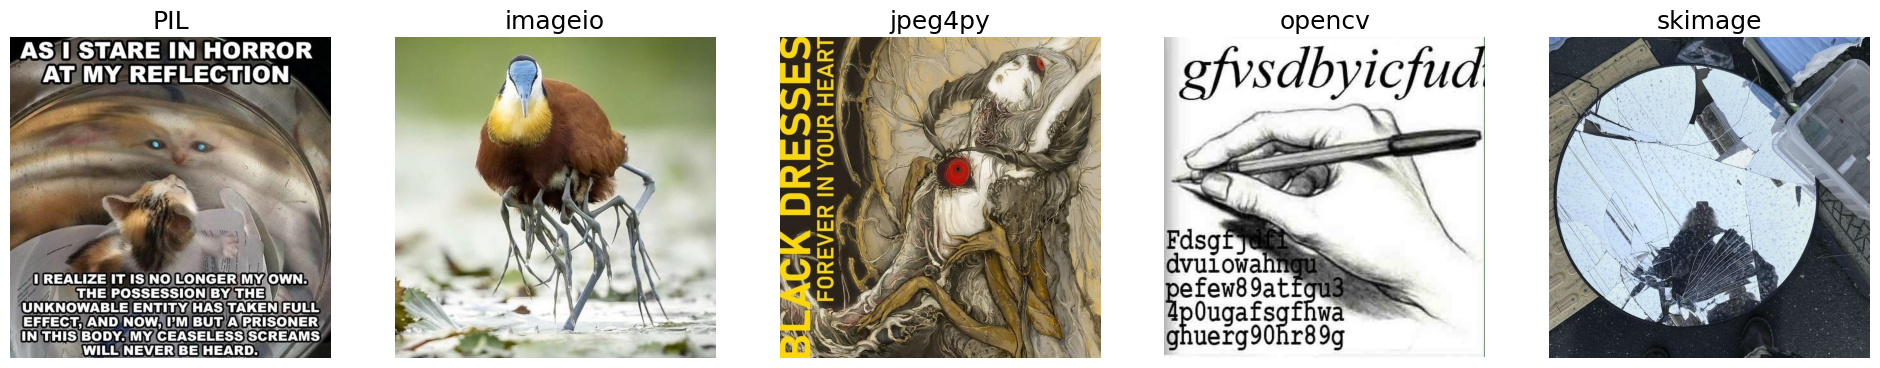

In [30]:
# PIL -> Pillow -> Pillow-SIMD
class GetArray:
    def PIL(self, image_path: str) -> np.array:
        img = Image.open(image_path)
        img = img.convert("RGB")
        return np.asarray(img)

    def opencv(self, image_path: str) -> np.array:
        img = cv2.imread(image_path)
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    def jpeg4py(self, image_path: str) -> np.array:
        return jpeg4py.JPEG(image_path).decode()

    def skimage(self, image_path: str) -> np.array:
        return skimage.io.imread(image_path, plugin="matplotlib")

    def imageio(self, image_path: str) -> np.array:
        return imageio.v2.imread(image_path)


array_getter = GetArray()
methods_pool = inspect.getmembers(array_getter, predicate=inspect.ismethod)
print("Methods pool: ", [method_name for method_name, method in methods_pool], "\n")

fig, axs = plt.subplots(1, 5, figsize=(24, 6))

for i, ax in enumerate(axs):
    ax.axis("off")
    ax.imshow(methods_pool[i][1](f"pics/{i + 1}.jpg"))
    ax.set_title(methods_pool[i][0], fontsize=18)

![image_decoding](image_decoding.png)

Now, examine `image_loaders_benchmark.py` code, which runs image decoding with the frameworks above 2000 times and check time consumption of each algorithm.

Run `python image_loaders_benchmark.py -d pics/`.

## Profiling

### py-spy

For general purpose Python profiling we can use `py-spy` or [`scalene`](https://github.com/plasma-umass/scalene). The main advantage of such tools is that no interaction with source code is needed. You can even attach profiler to a running process.

Examine `mnist_trainig.py`.

Run `sudo py-spy record -o profile.svg --pid <get_pid>`.

Run `sudo py-spy top --pid <get_pid>`.

Try different model and transforms levels.

### `torch.utils.bottleneck`

Run `python -m torch.utils.bottleneck mnist_train.py -m 1 -t 1 --n-epochs 1` with and without amp.

**Important note:** make sure that your scripts ends in reasonable amount of time, since `torch.utils.bottleneck` will run it several times.

### Pytorch profiler

Source of the section and more info can be found [here](https://pytorch.org/tutorials/recipes/recipes/profiler_recipe.html).

In [31]:
import torch
import torchvision.models as models
from torch.profiler import ProfilerActivity, profile, record_function

In [32]:
model = models.resnet18()
inputs = torch.randn(5, 3, 224, 224)

In [33]:
with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        model(inputs)

In [34]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference         2.81%       5.268ms        99.97%     187.700ms     187.700ms             1  
                     aten::conv2d         0.09%     161.000us        78.53%     147.449ms       7.372ms            20  
                aten::convolution         0.25%     467.000us        78.45%     147.288ms       7.364ms            20  
               aten::_convolution         0.18%     343.000us        78.20%     146.821ms       7.341ms            20  
         aten::mkldnn_convolution        77.83%     146.134ms        78.02%     146.478ms       7.324ms            20  
                 aten::batch_norm       

In [35]:
print(
    prof.key_averages(group_by_input_shape=True).table(
        sort_by="cpu_time_total", row_limit=10
    )
)

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls                                                                      Input Shapes  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                  model_inference         2.81%       5.268ms        99.97%     187.700ms     187.700ms             1                                                                                []  
                     aten::conv2d         0.02%      41.000us        22.75%      42.715ms      10.679ms             4                             [[5, 64, 56, 56], [64, 64, 3, 3], [], [], [], 

In [36]:
model = models.resnet18().cuda()
inputs = torch.randn(5, 3, 224, 224).cuda()

with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True
) as prof:
    with record_function("model_inference"):
        model(inputs)

print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         0.11%       2.761ms       100.00%        2.486s        2.486s       0.000us         0.00%       2.371ms       2.371ms             1  
                                           aten::conv2d         0.00%     111.000us        99.64%        2.477s     123.870ms       0.000us         0.00%       1.800ms      90.000us            20  
         

In [37]:
model = models.resnet18()
inputs = torch.randn(5, 3, 224, 224)

with profile(
    activities=[ProfilerActivity.CPU], profile_memory=True, record_shapes=True
) as prof:
    model(inputs)

print(prof.key_averages().table(sort_by="self_cpu_memory_usage", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                      aten::empty         0.45%     552.000us         0.45%     552.000us       2.760us      94.86 Mb      94.86 Mb           200  
    aten::max_pool2d_with_indices         7.72%       9.371ms         7.72%       9.371ms       9.371ms      11.48 Mb      11.48 Mb             1  
                      aten::addmm         0.13%     162.000us         0.14%     175.000us     175.000us      19.53 Kb      19.53 Kb             1  
                       aten::mean         0.02%      20.000us         0.08%     101.000us     101.000us      10.

### Tensor cores usage

We can check whether our code enables tensor cores or not. This notebook was run on the machine with Nvidia V100 and output of the `nvprof` profiler shows one of the kernels which corresponds to the tensor core activation: `volta_fp16_s884gemm`.

Run `nvprof python tc_test.py` to check if half precision computations enable tensor cores on your machine.

### cProfile

Yet another way to profile your code. Basically, cProfile is used in Pytorch profiler.

In [38]:
import numpy as np

In [39]:
def step(*shape):
    # Create a random n-vector with +1 or -1 values.
    return 2 * (np.random.random_sample(shape) < 0.5) - 1

In [40]:
%%prun -s cumulative -q -l 10 -T prun0
# We profile the cell, sort the report by "cumulative
# time", limit it to 10 lines, and save it to a file
# named "prun0".

n = 10000
iterations = 50
x = np.cumsum(step(iterations, n), axis=0)
bins = np.arange(-30, 30, 1)
y = np.vstack([np.histogram(x[i,:], bins)[0]
               for i in range(iterations)])

 
*** Profile printout saved to text file 'prun0'.


In [41]:
print(open("prun0", "r").read())

         2579 function calls (2277 primitive calls) in 0.029 seconds

   Ordered by: cumulative time
   List reduced from 57 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.029    0.029 {built-in method builtins.exec}
        1    0.000    0.000    0.028    0.028 <string>:1(<module>)
   354/52    0.001    0.000    0.022    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
        1    0.000    0.000    0.019    0.019 <string>:9(<listcomp>)
       50    0.000    0.000    0.019    0.000 <__array_function__ internals>:177(histogram)
       50    0.001    0.000    0.019    0.000 histograms.py:678(histogram)
       50    0.000    0.000    0.012    0.000 <__array_function__ internals>:177(sort)
       50    0.000    0.000    0.012    0.000 fromnumeric.py:878(sort)
       50    0.011    0.000    0.011    0.000 {method 'sort' of 'numpy.ndarray' objects}
        1    0.001    0.00

## Bonus material: data preprocessing with DALI
Main page:

https://docs.nvidia.com/deeplearning/dali/user-guide/docs/index.html

Augmentations:

https://docs.nvidia.com/deeplearning/dali/user-guide/docs/examples/image_processing/augmentation_gallery.html

Images decoders:

https://docs.nvidia.com/deeplearning/dali/user-guide/docs/examples/image_processing/decoder_examples.html

For images check out source for ResNet50 on ImageNet:

https://docs.nvidia.com/deeplearning/dali/user-guide/docs/examples/use_cases/pytorch/resnet50/pytorch-resnet50.html